# Builder Tutorial number 11

The builder tutorials demonstrate how to build an operational GSFLOW model using `pyGSFLOW` from shapefile, DEM, and other common data sources. These tutorials focus on the `gsflow.builder` classes.

## Assembling a GSFLOW model from MODFLOW and PRMS components

In this final builder tutorial, we show how to assemble a GSFLOW model from the previously built MODFLOW, PRMS, and CONTROl file components. After assembling the model, final adjustments to parameter values are applied and the model is run. 

In [1]:
import os
import shapefile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import flopy
import platform
from gsflow.builder import builder_utils as bu
import gsflow

# silence pandas setting with copy warning
pd.options.mode.chained_assignment = None

# register pandas plotting converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Applying the methods to the Sagehen 50m model

In this example the methods presented are applied directly to Sagehen 50m model.

### Loading the model components

Prior to assembling the GSFLOW model, model components must be loaded using pyGSFLOW built in methods. 

Let's start by defining paths and the Loading the PRMS parameter and data files, MODFLOW model, and GSFLOW control file.

In [2]:
# define the input and output data paths
input_ws = os.path.join("data", "sagehen", "50m_tutorials")
geospatial_ws = os.path.join("data", "geospatial")
output_ws = os.path.join("data", "temp")

modflow_nam = "sagehen_50m.nam"
parameter_file = os.path.join(input_ws, "sagehen_50m_ncal.param")
data_file = os.path.join(input_ws, "sagehen_50m.data")
control_file = os.path.join(input_ws, "sagehen_50m_initial.control")

Load each of the GSFLOW model components

In [3]:
# MODFLOW
ml = gsflow.modflow.Modflow.load(modflow_nam, model_ws=input_ws)

# PRMS
parameters = gsflow.prms.PrmsParameters.load_from_file(parameter_file)
prms_data = gsflow.prms.PrmsData.load_from_file(data_file)

# GSFLOW Control File
control = gsflow.ControlFile.load_from_file(control_file)

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:
------------------------------------
Reading parameter file : sagehen_50m_ncal.param
------------------------------------


### Assembling the PRMS model from components with `PrmsModel`

Before a GSFLOW model can be assembled, the user must first assemble a PRMS model using the `PrmsModel` container. The `PrmsModel` container object holds all components of the PRMS surface water model and has the following input parameters:
   - `control` : a gsflow.ControlFile object, required
   - `parameters` : a gsflow.prms.PrmsParameters object, optional
   - `data` : a gsflow.prms.PrmsData object, optional
   - `day` : An optional dictionary of gsflow.prms.PrmsDay objects, dictionary key for each object must be the same as the budget by hru variable name. 
   
Let's assemble the PRMS model for the sagehen 50m model.

In [4]:
prms = gsflow.prms.PrmsModel(control, parameters=parameters, data=prms_data)

Inspecting the PRMS object

In [5]:
print(prms)
print(prms.parameters)
print(prms.data)
print(prms.day)

None


### Assembling the GSFLOW model 

Now that the `PrmsModel` object has been assembled, the GSFLOW model can be assembled from the prms and modflow model objects. The `GsflowModel` class allows the user to assemble a GSFLOW model and has the following parameters:
   - `control` : a gsflow.ControlFile object
   - `prms` : optional gsflow.PrmsModel object
   - `mf` : optional gsflow.modflow.Modflow object
   - `modflow_only` : optional boolean flag, if True class can be instantiated with only a control object and a modflow object
   - `prms_only` : optional boolean flag, if True class can be instantiated with only a control and prms model object
   - `modsim` : optional boolean flag, if True on model write a MODSIM compatible stream vector shapefile is produced from SFR and LAK package information.
   
Let's assemble the Sagehen 50m GSFLOW model!

In [6]:
gsf = gsflow.GsflowModel(control, prms=prms, mf=ml)

Inspecting the `GsflowModel` object

In [7]:
print(gsf)
print(gsf.mf)
print(gsf.prms)
print(gsf.prms.parameters)
print(gsf.prms.data)

MODFLOW 1 layer(s) 138 row(s) 149 column(s) 2 stress period(s)


### Adding required records to the GSFLOW control file object

Before writing and running the model, a few required records need to added and/or updated in the GSFLOW control file to 1) add the PRMS data file, 2) sync the PRMS and MODFLOW models, and 3) produce the desired output from the GSFLOW model.

These parameters are shown in the code block below

In [8]:
start_time = [1982, 10, 1, 0, 0, 0]
end_time = [1996, 9, 31, 0, 0, 0]

# control file records to add
gsf.control.add_record("data_file", ["sagehen_50m.data",])
gsf.control.add_record("modflow_time_zero", start_time)
gsf.control.add_record("end_time", end_time)

# control file output control records added
gsf.control.add_record("print_debug", [0,])
gsf.control.add_record("statsON_OFF", [1,])
gsf.control.add_record("nstatVars", [6,])
gsf.control.add_record("statVar_element", ["1",] * 6)
gsf.control.add_record(
    "statVar_names",
    values=[
        "runoff",
        "basin_cfs",
        "basin_ssflow_cfs",
        "basin_gwflow_cfs",
        "basin_sroff_cfs",
        "basin_dunnian"
    ]
)
gsf.control.add_record("stat_var_file", ["statvar.dat",])

In [9]:
# control file records to edit
gsf.control.start_time = start_time
gsf.control.model_mode = ["GSFLOW5",]
gsf.control.subbasin_flag = [0,]
gsf.control.parameter_check_flag = [0,]
gsf.control.srunoff_module = ["srunoff_smidx"]

### Writing the assembled GSFLOW model to file

In this example we show how to write the assembled GSFLOW model to file using the built in `write()` method. The `write()` method has three optional parameters, however in the case of new model assembly the first two should both always be used!
   - `basename` : the "basename" for all model files, in this case it will be "sagehen_50m"
   - `workspace` : the folder path for model files to be written to
   - `write_only` : optional list that allows the user to write only the "control", "parameters", "prms_data", "mf", or "modsim" or a combinations of parts of the GSFLOW model 

In [10]:
gsf.write_input(basename="sagehen_50m", workspace=output_ws)

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Modflow files...


### Running the uncalibrated model

The uncalibrated GSFLOW model can be run using the built in `run_model()` method. The `run_model()` method has 4 optional parameters:
   - `model_ws` : path to model directory
   - `forgive` : boolean flag, which forgives convergence issues (will return True for successful run)
   - `gsflow_exe` : optional path to the gsflow executable
   - `silent` : boolean flag to silence model output from being written to the screen. Default is False
   
Note: change `run_model = True` to `run_model = False` to skip the model run. The model run takes about 20 minutes to complete. Output has been saved for this example and results will load regardless of model run status.

In [11]:
run_model = True

In [12]:
gsflow_exe = os.path.join("..", "bin", "gsflow")
if platform.system().lower() == "windows":
    gsflow_exe += ".exe"

if run_model:
    gsf.run_model(gsflow_exe=gsflow_exe, silent=True)

Now load in the statsvar file using the built in method `get_StatVar()` and examine the output

In [13]:
try:
    stats = gsf.prms.get_StatVar()
except FileNotFoundError:
    print("@@@@@ Loading cached output @@@@@@")
    statvar = gsflow.output.StatVar(os.path.join(input_ws, "sagehen_50m_stat_var.dat"))
    stats = statvar.stat_df
stats.head()

Loading the statvar output file .....
Finished Load the statvar output file .....


,ID,Year,Month,Day,Hour,Minute,Second,runoff_1,basin_cfs_1,basin_ssflow_cfs_1,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_dunnian_1,Date
0,1,1982,10,1,0,0,0,6.4,0.2080,0.0,-0.2080,0.0,0.0,1982-10-01
1,2,1982,10,2,0,0,0,5.8,0.1797,0.0,-0.1797,0.0,0.0,1982-10-02
2,3,1982,10,3,0,0,0,5.3,0.1593,0.0,-0.1593,0.0,0.0,1982-10-03
3,4,1982,10,4,0,0,0,5.0,0.1422,0.0,-0.1422,0.0,0.0,1982-10-04
4,5,1982,10,5,0,0,0,4.9,0.1277,0.0,-0.1277,0.0,0.0,1982-10-05


In [14]:
# get data from 10/1/1985 onward
stats = stats[1096:]
stats.reset_index(inplace=True, drop=True)

plot simulated vs. measured streamflow results

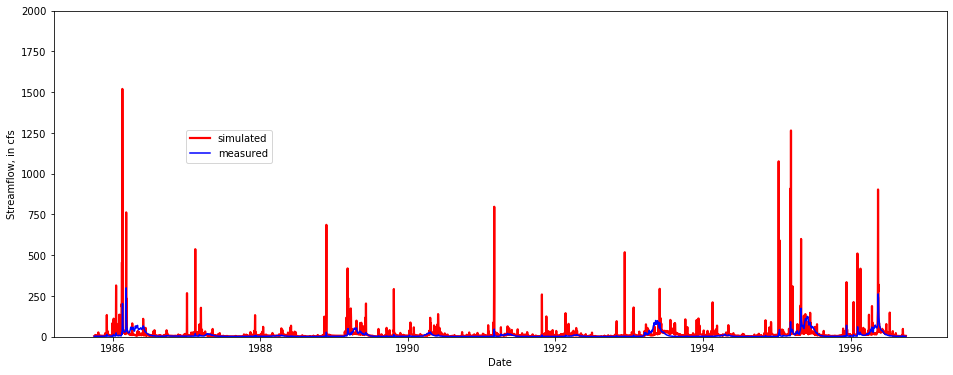

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(stats.Date, stats.basin_cfs_1, color='r', linewidth=2.2, label="simulated")
ax.plot(stats.Date, stats.runoff_1, color='b', linewidth=1.5, label="measured")
ax.legend(bbox_to_anchor=(0.25, 0.65))
ax.set_xlabel("Date")
ax.set_ylabel("Streamflow, in cfs")
ax.set_ylim([0, 2000]);

Plot surface water contributions to streamflow

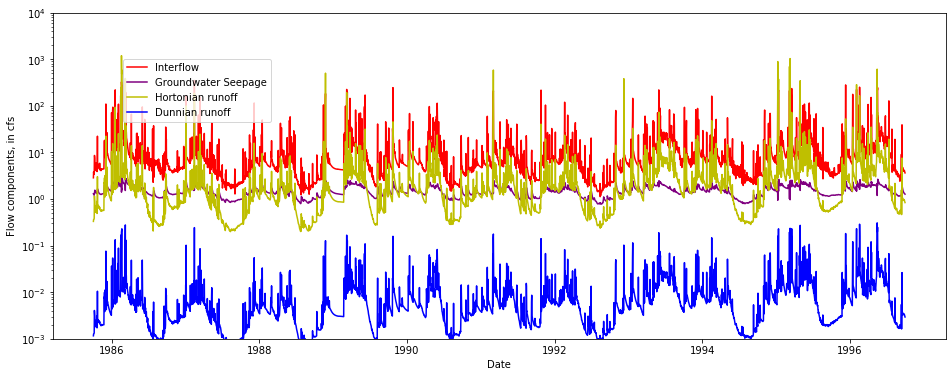

In [16]:
gw_seepage = stats.basin_cfs_1.values - (
    stats.basin_ssflow_cfs_1.values + 
    stats.basin_sroff_cfs_1.values +
    stats.basin_dunnian_1.values
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(stats.Date, stats.basin_ssflow_cfs_1, color='r', linewidth=1.5, label="Interflow")
ax.plot(stats.Date, gw_seepage, color='purple', linewidth=1.5, label="Groundwater Seepage")
ax.plot(stats.Date, stats.basin_sroff_cfs_1, color="y", linewidth=1.5, label="Hortonian runoff")
ax.plot(stats.Date, stats.basin_dunnian_1, color="b", linewidth=1.5, label="Dunnian runoff")
ax.legend(bbox_to_anchor=(0.25, 0.65))
ax.set_xlabel("Date")
ax.set_ylabel("Flow components, in cfs")
ax.set_yscale("log")
ax.set_ylim([1e-03, 1e4]);

### Model adjustments for a calibrated result

Model calibration adjustments for the sagehen 50m model were performed in a stepwise fashion by hand. Here we adjust the parameters to their final calibrated values and re-run the model. 

#### Modify PRMS parameters

In [17]:
# temp distribution
v = gsf.prms.parameters.tmax_lapse.values
gsf.prms.parameters.tmax_lapse += 1.2
gsf.prms.parameters.tmin_lapse += 1.2
gsf.prms.parameters.set_values(
    "max_missing",
    gsf.prms.parameters.max_missing.values * 2
)

# snow 
gsf.prms.parameters.tmax_allsnow[:] = 0.7
covden_win = gsf.prms.parameters.covden_win.values
gsf.prms.parameters.rad_trncf[:] = covden_win * 0.8
gsf.prms.parameters.add_record(
    "tmax_allrain_offset",
    values=[2.1,] * 12,
    dimensions=[["nmonths", 12]]
)

# ET
gsf.prms.parameters.soil_moist_max *= 3.0
gsf.prms.parameters.add_record(
    "jh_coef", 
    values=[0.03,] * 12, 
    dimensions=[('nmonths', 12)]
)

# runoff
print(gsf.prms.parameters.snowinfil_max.values)
gsf.prms.parameters.snowinfil_max *= 5
print(gsf.prms.parameters.snowinfil_max.values)
gsf.prms.parameters.smidx_coef /= 100
gsf.prms.parameters.smidx_exp /= 100
gsf.prms.parameters.carea_max /= 100

# Interflow
gsf.prms.parameters.slowcoef_sq *= 0.1
gsf.prms.parameters.slowcoef_lin *= 3.0

# Recharge
gsf.prms.parameters.ssr2gw_rate *= 500
gsf.prms.parameters.sat_threshold /= 3

[2. 2. 2. ... 2. 2. 2.]
[10. 10. 10. ... 10. 10. 10.]


#### Write calibrated model to file

In [18]:
gsf.write_input(basename="sagehen_50m_cal", workspace=output_ws)

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Modflow files...


### Running the calibrated model

The calibrated GSFLOW model can be run using the built in `run_model()` method. The `run_model()` method has 4 optional parameters:
   - `model_ws` : path to model directory
   - `forgive` : boolean flag, which forgives convergence issues (will return True for successful run)
   - `gsflow_exe` : optional path to the gsflow executable
   - `silent` : boolean flag to silence model output from being written to the screen. Default is False
   
Note: change `run_model = True` to `run_model = False` to skip the model run. The model run takes about 20 minutes to complete. Output has been saved for this example and results will load regardless of model run status.

In [19]:
run_model = True

In [20]:
gsflow_exe = os.path.join("..", "bin", "gsflow")
if platform.system().lower() == "windows":
    gsflow_exe += ".exe"

if run_model:
    gsf.run_model(gsflow_exe=gsflow_exe, silent=True)

### Get calibrated model results from the statistics variables file

Load in the statsvar file using the built in method `get_StatVar()` and examine the output

In [21]:
try:
    stats = gsf.prms.get_StatVar()
except FileNotFoundError:
    print("@@@@@ Loading cached output @@@@@@")
    statvar = gsflow.output.StatVar(os.path.join(input_ws, "sagehen_50m_cal_stat_var.dat"))
    stats = statvar.stat_df
stats.head()

Loading the statvar output file .....
Finished Load the statvar output file .....


,ID,Year,Month,Day,Hour,Minute,Second,runoff_1,basin_cfs_1,basin_ssflow_cfs_1,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_dunnian_1,Date
0,1,1982,10,1,0,0,0,6.4,0.2080,0.0,-0.2080,0.0,0.0,1982-10-01
1,2,1982,10,2,0,0,0,5.8,0.1797,0.0,-0.1797,0.0,0.0,1982-10-02
2,3,1982,10,3,0,0,0,5.3,0.1593,0.0,-0.1593,0.0,0.0,1982-10-03
3,4,1982,10,4,0,0,0,5.0,0.1422,0.0,-0.1422,0.0,0.0,1982-10-04
4,5,1982,10,5,0,0,0,4.9,0.1277,0.0,-0.1277,0.0,0.0,1982-10-05


In [22]:
# get data from 10/1/1985 onward
stats = stats[1096:]
stats.reset_index(inplace=True, drop=True)

#### plot simulated vs. measured streamflow results

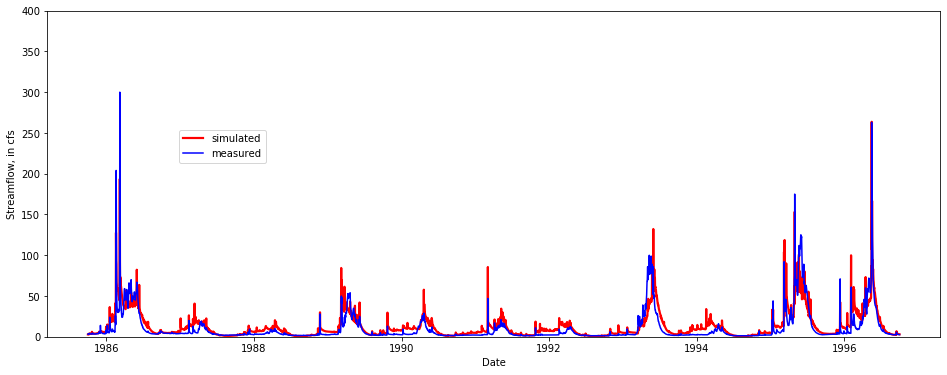

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(stats.Date, stats.basin_cfs_1, color='r', linewidth=2.2, label="simulated")
ax.plot(stats.Date, stats.runoff_1, color='b', linewidth=1.5, label="measured")
ax.legend(bbox_to_anchor=(0.25, 0.65))
ax.set_xlabel("Date")
ax.set_ylabel("Streamflow, in cfs")
ax.set_ylim([0, 400]);

#### plot surface water contribution to streamflow

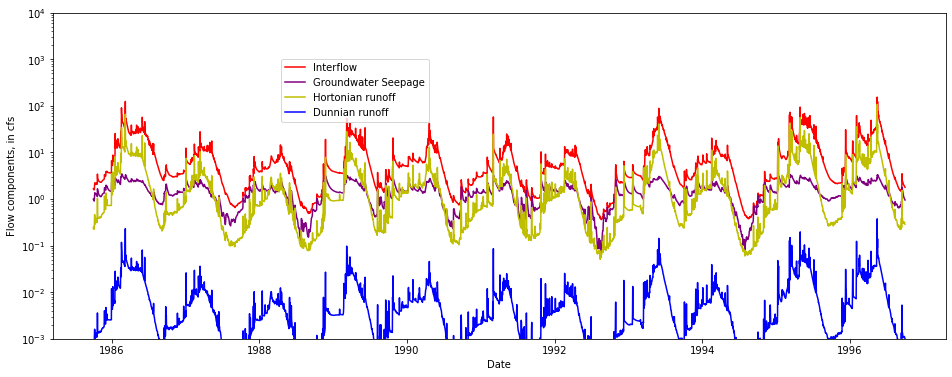

In [24]:
gw_seepage = stats.basin_cfs_1.values.copy() - (
    stats.basin_ssflow_cfs_1.values.copy() + 
    stats.basin_sroff_cfs_1.values.copy() +
    stats.basin_dunnian_1.values.copy()
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(stats.Date, stats.basin_ssflow_cfs_1, color='r', linewidth=1.5, label="Interflow")
ax.plot(stats.Date, gw_seepage, color='purple', linewidth=1.5, label="Groundwater Seepage")
ax.plot(stats.Date, stats.basin_sroff_cfs_1, color="y", linewidth=1.5, label="Hortonian runoff")
ax.plot(stats.Date, stats.basin_dunnian_1, color="b", linewidth=1.5, label="Dunnian runoff")
ax.legend(bbox_to_anchor=(0.25, 0.65))
ax.set_xlabel("Date")
ax.set_ylabel("Flow components, in cfs")
ax.set_yscale("log")
ax.set_ylim([1e-03, 1e4]);

## This concludes the pyGSFLOW builder tutorials.

These tutorials outline GSFLOW model building starting from Raster data and going to a fully operational model. The example problem Sagehen 50m was used to demonstrate this process.